# Jupyter Notebook for the ROI Branch

## Code to crop images down to edges

In [6]:
# State: works
# ToDo: works only on squares/rectangles and specific sizes atm
'''
Imports:
'''
import cv2
import numpy as np
import X_Code.variables as v
from matplotlib import pyplot as plt

'''
Code:
'''
def crop(img, gray, blur):

    # threshold and morph-close-op
    retval, threshed = cv2.threshold(blur, 110, 255, cv2.THRESH_BINARY_INV)
    closed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, v.kernel2)

    # project to the axis
    H,W = img.shape[:2]
    xx = np.sum(closed, axis=0)/H
    yy = np.sum(closed, axis=1)/W

    # threshold and find the nozero
    xx[xx<60] = 0
    yy[yy<100] = 0

    ixx = xx.nonzero()
    iyy = yy.nonzero()
    x1,x2 = ixx[0][0], ixx[0][-1]
    y1,y2 = iyy[0][0], iyy[0][-1]

    # label on the original image and save it.
    lined = cv2.rectangle(img.copy(), (x1,y1),(x2,y2), (0,0,255),2)
    cropped = img[y1:y2,x1:x2]

    # opencv
    #cv2.imshow("Lined.png", lined)
    #cv2.imshow("Cropped.png", cropped)
    #cv2.waitKey(0)

    # matplotlib
    plt.imshow(lined)
    plt.show()
    plt.imshow(cropped)
    plt.show()

crop(v.image_int, v.image_gray1, v.image_median1)

IndexError: index 0 is out of bounds for axis 0 with size 0

## Code to test various segmentation methods

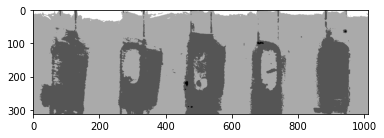

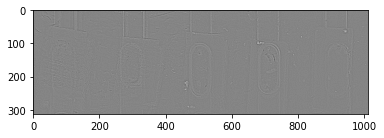

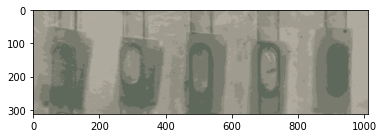

In [3]:
# State: 
# ToDo: 
'''
Imports:
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import X_Code.variables as v

'''
Additional Imports:
'''
from scipy import ndimage
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

'''
Code:
'''
def region_segmentation(image):

    gray = rgb2gray(image)
    gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
    for i in range(gray_r.shape[0]):
        if gray_r[i] > gray_r.mean():
            gray_r[i] = 3
        elif gray_r[i] > 0.5:
            gray_r[i] = 2
        elif gray_r[i] > 0.25:
            gray_r[i] = 1
        else:
            gray_r[i] = 0

    gray = gray_r.reshape(gray.shape[0],gray.shape[1])
    plt.imshow(gray, cmap='gray')
    plt.show()

def edge_segmentation(image):

    gray = rgb2gray(image)

    out_l = ndimage.convolve(gray, v.kernel_laplacian, mode='reflect')
    plt.imshow(out_l, cmap='gray')
    plt.show()

def cluster_segmentation(path):

    pic = plt.imread(path)/255  # divide by 255 to set pixel values between 0 and 1
    pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
    pic_n.shape

    kmeans = KMeans(n_clusters=5, random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]

    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])

    plt.imshow(cluster_pic)
    plt.show()

''' 
Call:
'''
region_segmentation(v.image_ext)
edge_segmentation(v.image_ext)
cluster_segmentation(v.path_image)

## Code to detect shapes

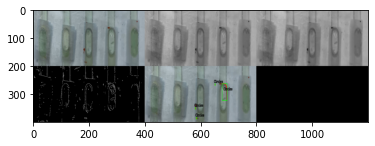

In [5]:
# State: works 
# ToDo: needs adjustment for 'images'
'''
Imports:
'''
import cv2
import numpy as np
import X_Code.variables as v

'''
Code:
'''
def get_contours(img, drawContour, gray, blur, canny): # img only takes canny images originating from gray color model, additionaly only uses the latest 4 arguments for showcasing
    
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for cnt in contours: # cnt represents contour values
        area = cv2.contourArea(cnt)
        #print(area) # maybe use values to cut to edges?
        
        if  60 > area > 15 : # adjust for needed object size
            cv2.drawContours(drawContour, cnt, -1, (255,0,0), 3)
            peri = cv2.arcLength(cnt, True) # get contour parameter
            #print(peri)

            approx = cv2.approxPolyDP(cnt, 0.02*peri, True) # adjust here for image
            #print(len(approx))
            objCor = len(approx)
            x, y, w, h = cv2.boundingRect(approx)

            if objCor == 3: objectType = "Tri"
            elif objCor == 4:
                aspRatio = w/float(h)
                if aspRatio > 0.98 and aspRatio < 1.03: objectType = "Square"
                else: objectType = "Rectangle"
            elif objCor > 4: objectType = "Circles"
            else: objectType = "None"

            cv2.rectangle(drawContour, (x,y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(drawContour,objectType,
                        (x+(w//2)-10,y+(h//2)-10),cv2.FONT_HERSHEY_COMPLEX,0.7,
                        (0,0,0),2)
            
            image_stacked = v.stackImages(0.8, ([v.image_int, gray, blur],
                                                [canny, drawContour, v.image_blank]))

            image_resized = cv2.resize(image_stacked, (1200, 400)) # function to resize image                               

    #cv2.imshow("Stacked", image_resized)
    #cv2.waitKey(0)
    plt.imshow(image_resized)
    plt.show()

# Show
get_contours(v.image_canny1, v.image_cp1, v.image_gray1, v.image_gaussian1, v.image_canny1)




## Code for Testing

In [10]:
import cv2
import numpy as np

import X_Code.variables as v

def test(img): # input grayscale image

    font = cv2.FONT_HERSHEY_COMPLEX  

    _, threshold = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        cv2.drawContours(img, [approx], 0, (0), 5)
        x = approx.ravel()[0]
        y = approx.ravel()[1]
        if len(approx) == 3:
            cv2.putText(img, "Triangle", (x, y), font, 1, (0))
        elif len(approx) == 4:
            cv2.putText(img, "Rectangle", (x, y), font, 1, (0))
        elif len(approx) == 5:
            cv2.putText(img, "Pentagon", (x, y), font, 1, (0))
        elif 6 < len(approx) < 15:
            cv2.putText(img, "Ellipse", (x, y), font, 1, (0))
        else:
            cv2.putText(img, "Circle", (x, y), font, 1, (0))

    cv2.imshow("shapes", img)
    cv2.imshow("Threshold", threshold)
    cv2.waitKey(0)
    cv2.destroyAllWindows()  

test(v.image_gray1)                 